# Càlcul de la signatura aplicada a funcions de distribució de probabilitat

L'objectiu d'aquest notebook és fer una exploració inicial de les diferents aplicacions pràctiques que pot tenir el càlcul de la signatura d'un camí, més en particular aplicacions relacionades amb l'aprenentatge automàtic.

En primer lloc compararem els valors que pren la signatura de les funcions de densitat de probabilitat de distribucions diferents en funció dels seus paràmetres. Després ens plantejarem si es possible entrenar un classificador utilitzant com a vector de característiques la signatura.

Finalment, 

Implementem funcions que generen un vector de dades a partir d'una funció donada (farem servir funcions de densitat de probabilitat). 

In [12]:
import numpy as np

def generate_timestamps(start, end, step):
    timestamps = []
    current = start
    while current < end:
        timestamps.append(current)
        current += step
    return np.array(timestamps)

def generate_values(timestamps, function):
    return np.array([function(t) for t in timestamps])


## Distribució exponencial

Fem el càlcul de la signatura discreta plana utilitzant valors generats a partir de la pdf d'una distribució exponencial. Farem servir un valor de mu = 0.

In [13]:
from scipy.stats import expon
import discrete_signature_lib.discrete_signature as ds
scale = 1
exponential = expon(scale=scale)
timestamps = generate_timestamps(0, 10, 0.1)
data = generate_values(timestamps, exponential.pdf)

signature = ds.FlatDiscreteSignature(values = data,timestamps = timestamps, k =3)
words = signature.get_words()
sig = signature.calculate_signature(0,10)

for i in range(len(words)):
    print(words[i], " : ",sig[i])

   :  1.0
0+  :  -0.999954600070238
0-  :  -0.999954600070238
0+0+  :  0.5249337885282682
0+0-  :  0.47497541367336055
0-0+  :  0.5249337885282682
0-0-  :  0.47497541367336055
0+0+0+  :  -0.192730360906432
0+0+0-  :  -0.17438737422914097
0+0-0+  :  -0.1577922214355665
0+0-0-  :  -0.1427742541582334
0-0+0+  :  -0.192730360906432
0-0+0-  :  -0.17438737422914097
0-0-0+  :  -0.1577922214355665
0-0-0-  :  -0.1427742541582334


Veiem com canvien els valors de la signatura de la funció de densitat amb diferents valors pel paràmetre d'escala. 

Tot i que no té sentit interpretear la signatura com a una funció discreta, posem els valor de la signatura en un gràfic per observar com canvien.

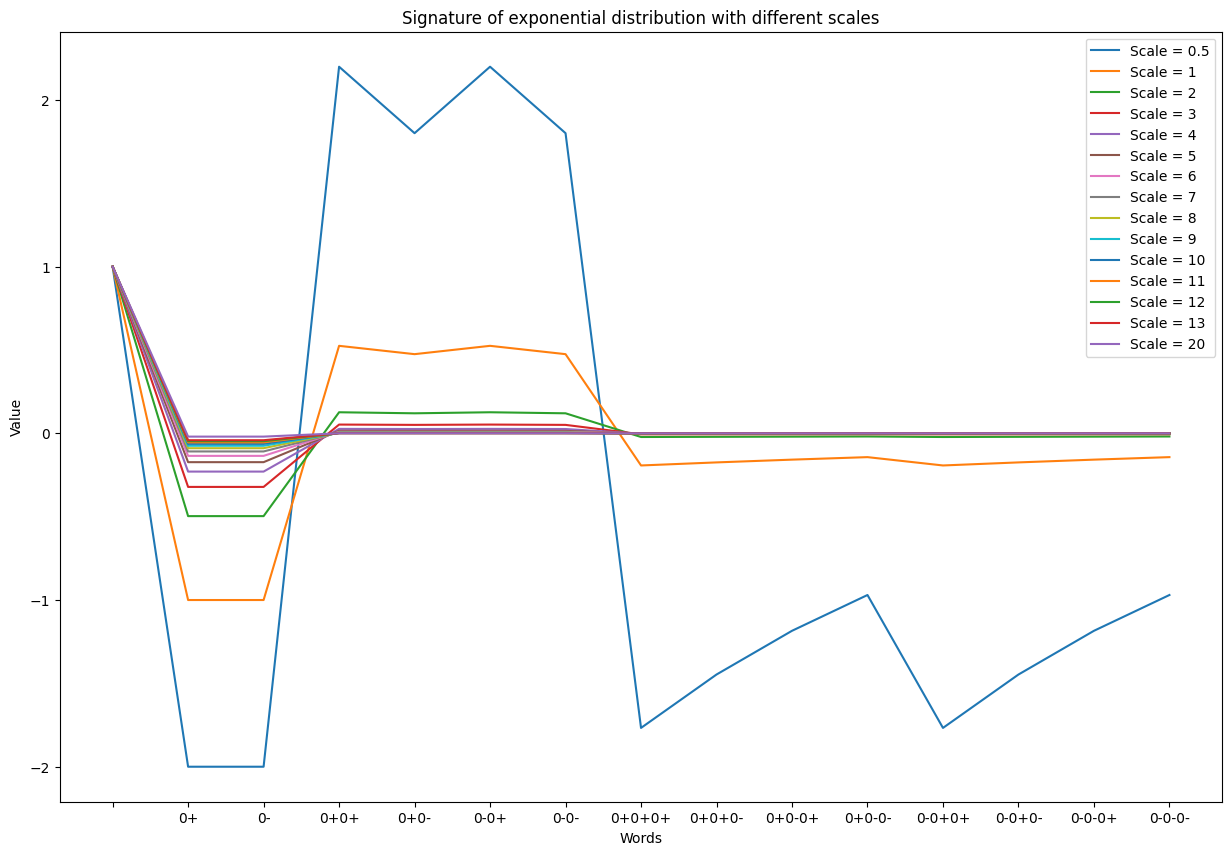

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,10))
scale = [0.5,1, 2,3,4,5,6,7,8,9,10,11,12,13,20]
x = list(range(0,len(words)))
xticks = list(words)
timestamps = generate_timestamps(0, 10, 0.1)
values_sig_exp = []
values_exp = []
for i,s in enumerate(scale): #plotting the signature of exponential distribution with different scales
    exponential = expon(scale=s)
    data = generate_values(timestamps, exponential.pdf)
    signature = ds.FlatDiscreteSignature(values = data,timestamps = timestamps, k =3)
    sig = signature.calculate_signature(0,10)
    if not np.isnan(sig).any():
        values_sig_exp.append(sig)
        values_exp.append(data)
    plt.plot(x,sig,label = "Scale = "+str(s))

plt.xlabel("Words")
plt.ylabel("Value")
plt.title("Signature of exponential distribution with different scales")
plt.xticks(x,xticks)
plt.legend()
plt.show()

## Distribució lognormal

Fem el mateix que acabem de fer amb la distribució exponencial, amb la distribució lognormal.

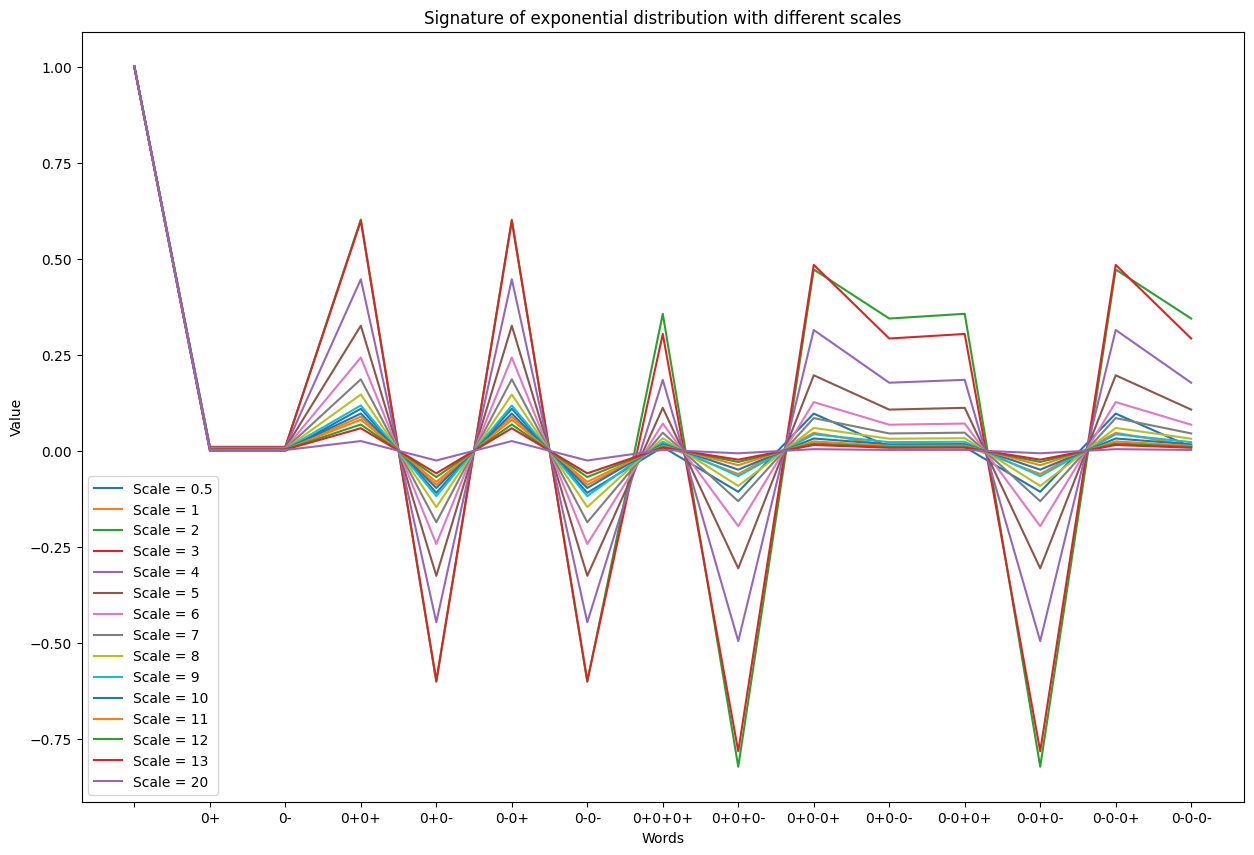

In [15]:
from scipy.stats import lognorm
plt.figure(figsize=(15,10))
sigma = [0.5,1,2,3,4,5,6,7,8,9,10,11,12,13,20]
mean = 0
values_lognorm = []
values_lognorm_sig = []
for i,s in enumerate(sigma): #plotting the signature of lognormal distribution with different scales
    lognormal_dist = lognorm(s,loc =mean)
    data = generate_values(timestamps, lognormal_dist.pdf)
    signature = ds.FlatDiscreteSignature(values = data,timestamps = timestamps, k =3)
    sig = signature.calculate_signature(0,10)
    if not np.isnan(sig).any():
        values_lognorm_sig.append(sig)
        values_lognorm.append(data)
    plt.plot(x,sig,label = "Scale = "+str(s))

plt.xlabel("Words")
plt.ylabel("Value")
plt.title("Signature of exponential distribution with different scales")
plt.xticks(x,xticks)
plt.legend()
plt.show()


## Distribució gamma

Fem el mateix amb la distribució gamma.

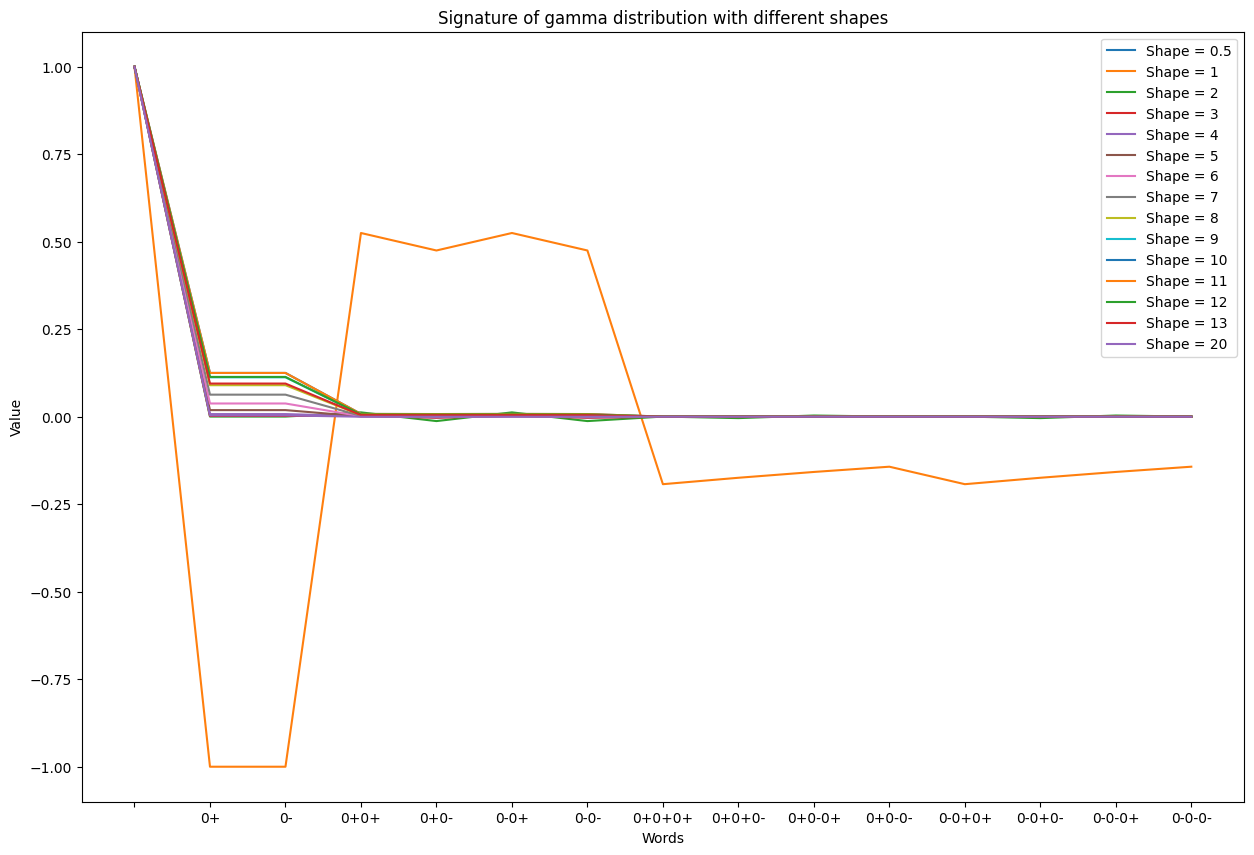

In [16]:
from scipy.stats import gamma
values_gamma = []
values_gamma_sig = []
plt.figure(figsize=(15,10))
shape = [0.5,1, 2,3,4,5,6,7,8,9,10,11,12,13,20]
scale = 1
for i,s in enumerate(shape): #plotting the signature of gamma distribution with different shapes
    gamma_dist = gamma(s,scale=scale)
    data = generate_values(timestamps, gamma_dist.pdf)
    signature = ds.FlatDiscreteSignature(values = data,timestamps = timestamps, k =3)
    sig = signature.calculate_signature(0,10)
    if not np.isnan(sig).any():
        values_gamma.append(data)
        values_gamma_sig.append(sig)
    plt.plot(x,sig,label = "Shape = "+str(s))

plt.xlabel("Words")
plt.ylabel("Value")
plt.title("Signature of gamma distribution with different shapes")
plt.xticks(x,xticks)
plt.legend()
plt.show()

## Ús de la signatura a un classificador 

En aquesta secció tenim l'intenció de fer servir la signatura com a vector de característiques per entrenar de forma naïve un model de classificació que determinarà a quina distribució pertany una certa funció de densitat. El classificador que farem servir serà RandomForest.

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
import warnings,time
warnings.filterwarnings("ignore")

X = np.array(values_exp + values_lognorm + values_gamma)
X_sig = np.array(values_sig_exp + values_lognorm_sig + values_gamma_sig)

y = ["Exponential"]*len(values_exp) + ["lognormal"]*len(values_lognorm) + ["Gamma"]*(len(values_gamma))
y_sig = ["Exponential"]*len(values_sig_exp) + ["lognormal"]*len(values_lognorm_sig) + ["Gamma"]*(len(values_gamma_sig))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) #splitting the data into train and test
X_train_sig, X_test_sig, y_train_sig, y_test_sig = train_test_split(X_sig, y_sig, test_size=0.3, random_state=42) #splitting the data into train and test

print ("Train size: ", len(X_train))
print ("Test size: ", len(X_test))

#Random Forest Classifier
start_time = time.time()
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)
print("Training time: ", time.time() - start_time)
start_time = time.time()
clf_sig = RandomForestClassifier(n_estimators=100)
clf_sig.fit(X_train_sig, y_train_sig)
print("Training time: ", time.time() - start_time)

#Accuracy and classification report
print("\nUsing default values with vectors of size ", len(X_train[0]))
print("Accuracy: ", clf.score(X_test, y_test))
print(classification_report(y_test, clf.predict(X_test)))

print("Using signature with vectors of size ", len(X_train_sig[0]))
print("Accuracy: ", clf_sig.score(X_test_sig, y_test_sig))
print(classification_report(y_test_sig, clf_sig.predict(X_test_sig)))



Train size:  30
Test size:  14
Training time:  0.08977556228637695
Training time:  0.0955510139465332

Using default values with vectors of size  101
Accuracy:  0.9285714285714286
              precision    recall  f1-score   support

 Exponential       1.00      1.00      1.00         5
       Gamma       1.00      0.80      0.89         5
   lognormal       0.80      1.00      0.89         4

    accuracy                           0.93        14
   macro avg       0.93      0.93      0.93        14
weighted avg       0.94      0.93      0.93        14

Using signature with vectors of size  15
Accuracy:  1.0
              precision    recall  f1-score   support

 Exponential       1.00      1.00      1.00         5
       Gamma       1.00      1.00      1.00         5
   lognormal       1.00      1.00      1.00         4

    accuracy                           1.00        14
   macro avg       1.00      1.00      1.00        14
weighted avg       1.00      1.00      1.00        14



Ara, ens proposem entrenar un classificador aportant com a vector de valors freqüencies experimentals generades segons una certa distribució en lloc de funcions de densitat de probabilitat. 

Generarem una sèrie de mostres seguint una distribució i discretitzarem les freqüències obtingudes en rangs del mateix tamany.

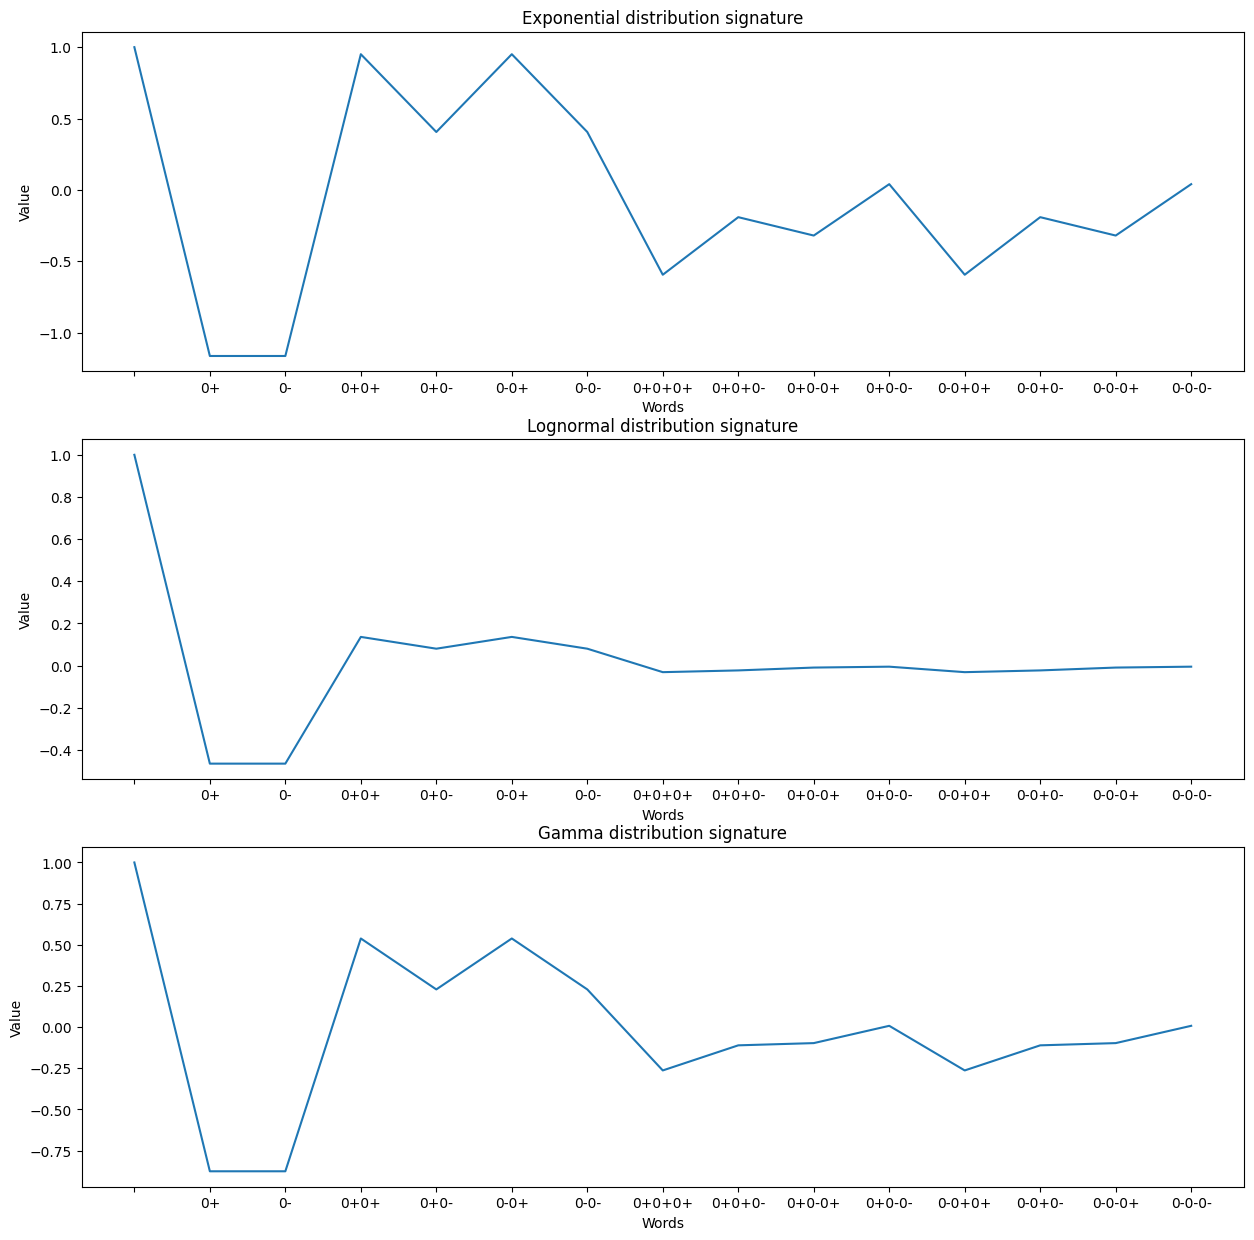

In [18]:
'''
Generate samples from exponential, lognormal and gamma distributions
 
'''

def generate_samples(num_samples,distribution,param,noise = 0):
    if distribution == "exp":
        samples = np.random.exponential(param,num_samples)
    elif distribution == "lognorm":
        samples = np.random.lognormal(param[0],param[1],num_samples)
    elif distribution == "gamma":
        samples = np.random.gamma(param[0],param[1],num_samples)
    else:
        raise ValueError("Invalid distribution")
    if noise != 0:
        samples += np.random.normal(0,noise,num_samples)
    

    return samples



def generate_data(num_samples,distribution,param,noise = 0,start = 0,end = 10,step = 0.1):
    samples = generate_samples(num_samples,distribution,param,noise)
    hist, bins = np.histogram(samples, bins = int((end-start)/step), density = True)
    return bins[:-1],hist

fig,ax = plt.subplots(3,1,figsize=(15,15))  

timestamps,values=generate_data(1000,"exp",1)
signature = ds.FlatDiscreteSignature(values = values,timestamps = timestamps, k =3)
words = signature.get_words()
sig = signature.calculate_signature(0,10)
x = list(range(0,len(words)))
ax[0].plot(x,sig)
ax[0].set_title("Exponential distribution signature")

timestamps,values=generate_data(1000,"lognorm",[0,1])
signature = ds.FlatDiscreteSignature(values = values,timestamps = timestamps, k =3)
sig = signature.calculate_signature(0,10)
ax[1].plot(x,sig)
ax[1].set_title("Lognormal distribution signature")

timestamps,values=generate_data(1000,"gamma",[1,1])
signature = ds.FlatDiscreteSignature(values = values,timestamps = timestamps, k =3)
sig = signature.calculate_signature(0,10)
ax[2].plot(x,sig)
ax[2].set_title("Gamma distribution signature")

for a in ax:
    a.set_xlabel("Words")
    a.set_ylabel("Value")
    a.set_xticks(x)
    a.set_xticklabels(words)
plt.show()








Generem mostres de cada distribució i entrenem el classificador:

Building gamma dataset: 100%|██████████| 10000/10000 [00:05<00:00, 1841.64it/s]


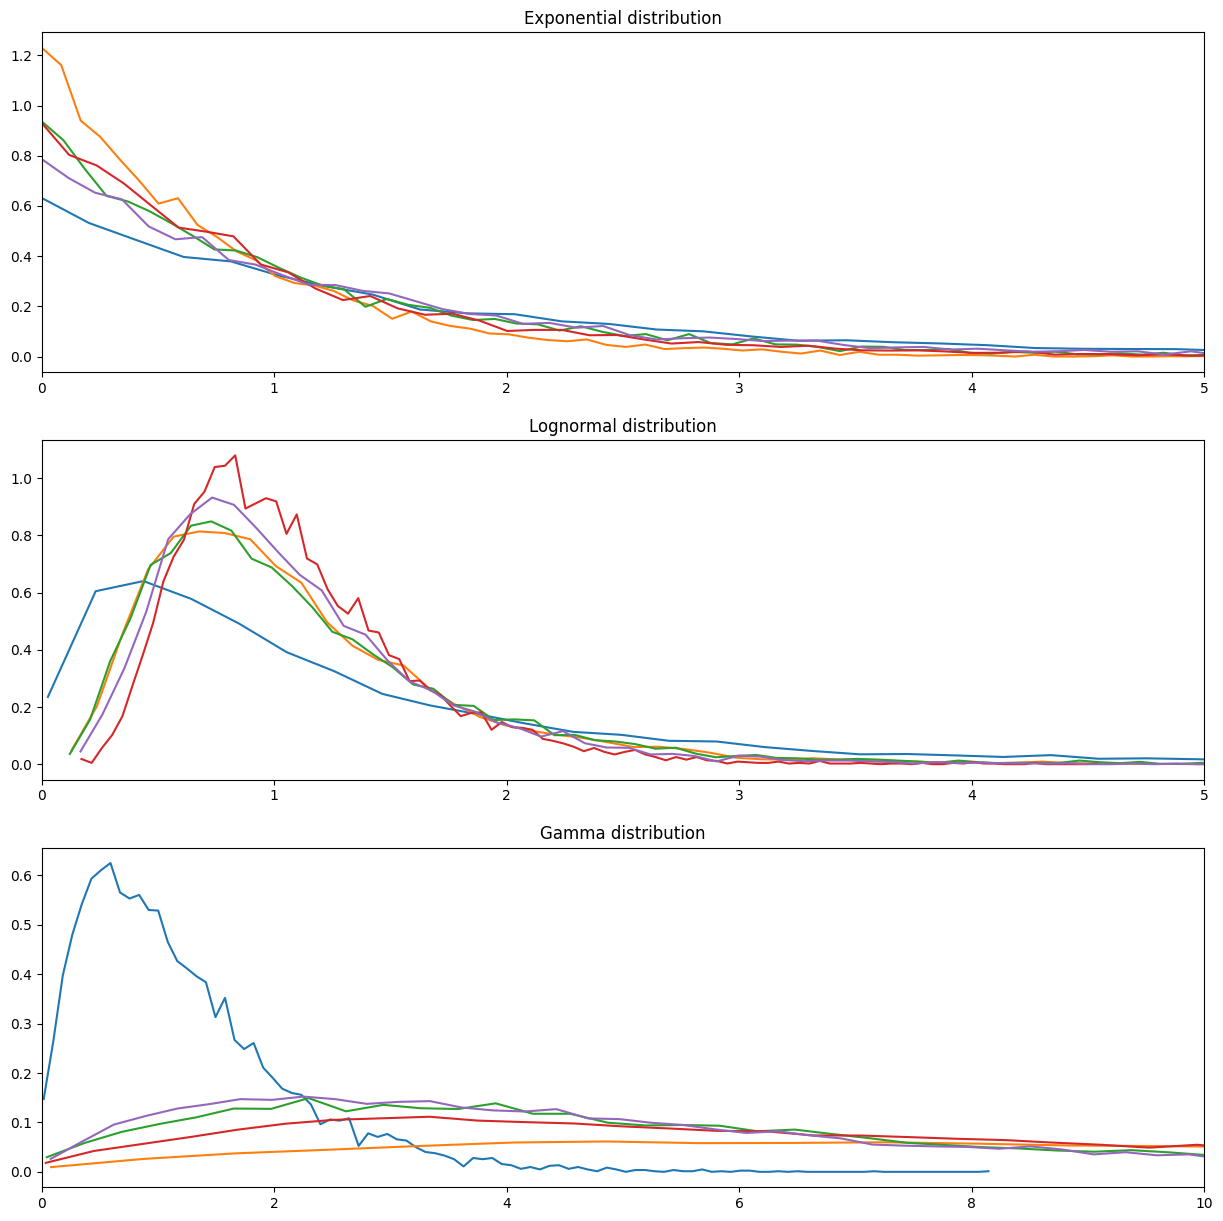

In [19]:
from tqdm import tqdm
fig,axes = plt.subplots(3,1,figsize=(15,15))
X = []
y = []
num_samples = 10000
dataset_size = 10000
count = 0
for i in tqdm(range(dataset_size),"Building exponential dataset"):
    scale = np.random.uniform(0.5,2)
    timestamps,values=generate_data(num_samples,"exp",scale)
    if count < 5:
        axes[0].plot(timestamps,values)
        count += 1

    X.append(values)
    y.append("Exponential")

count = 0
for i in tqdm(range(dataset_size),"Building lognormal dataset"):

    sigma = np.random.uniform(0.25,1)
    timestamps,values=generate_data(num_samples,"lognorm",(0,sigma))
    if count < 5:
        axes[1].plot(timestamps,values)
        count += 1
    X.append(values)
    y.append("lognormal")




count = 0
for i in tqdm(range(dataset_size),"Building gamma dataset"):
    shape = np.random.uniform(0.5,10)

    timestamps,values=generate_data(num_samples,"gamma",(2,shape))
    if count < 5:
        axes[2].plot(timestamps,values)
        count += 1
    X.append(values)
    y.append("Gamma")

axes[0].set_title("Exponential distribution")
axes[0].set_xlim(0,5)
axes[1].set_title("Lognormal distribution")
axes[1].set_xlim(0,5)
axes[2].set_title("Gamma distribution")
axes[2].set_xlim(0,10)

plt.show()

In [20]:
from sklearn.decomposition import PCA
#Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100)
clf_sig = RandomForestClassifier(n_estimators=100)
clf_pca = RandomForestClassifier(n_estimators=100)
X_sig = []
y_sig = []
k = 2
#Training with raw data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0) #splitting the data into train and test

start_time = time.time()
clf.fit(X_train, y_train)
time1 = time.time() - start_time


#Training with signature
X_train_sig = []
y_train_sig = []
y_test_sig = []
X_test_sig = []
for i in range(len(X_train)):
    signature = ds.FlatDiscreteSignature(values = X_train[i],timestamps = timestamps, k =k)
    sig = signature.calculate_signature(0,5)
    if not np.isnan(sig).any():
        X_train_sig.append(sig)
        y_train_sig.append(y_train[i])
for i in range(len(X_test)):
    signature = ds.FlatDiscreteSignature(values = X_test[i],timestamps = timestamps, k =k)
    sig = signature.calculate_signature(0,5)
    if not np.isnan(sig).any():
        X_test_sig.append(sig)
        y_test_sig.append(y_test[i])


start_time = time.time()

clf_sig.fit(X_train_sig, y_train_sig)
time2 = time.time() - start_time

vector_size = len(X_train_sig[0])
pca = PCA(n_components=vector_size)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
start_time = time.time()
clf_pca.fit(X_train_pca, y_train)
time3 = time.time() - start_time

#Accuracy and classification report
print("\nUsing default values with vectors of size ", len(X_train[0]))
print("Training time: ", time1) 
print("Accuracy: ", clf.score(X_test, y_test))
print(classification_report(y_test, clf.predict(X_test)))

print("Using signature with vectors of size ", len(X_train_sig[0]))
print("Training time: ", time2)
print("Accuracy: ", clf_sig.score(X_test_sig, y_test_sig))
print(classification_report(y_test_sig, clf_sig.predict(X_test_sig)))

print("Using PCA with vectors of size ", len(X_train_pca[0]))
print("Training time: ", time3)
print("Accuracy: ", clf_pca.score(X_test_pca, y_test))
print(classification_report(y_test, clf_pca.predict(X_test_pca)))




Using default values with vectors of size  100
Training time:  7.058307409286499
Accuracy:  0.9997777777777778
              precision    recall  f1-score   support

 Exponential       1.00      1.00      1.00      2993
       Gamma       1.00      1.00      1.00      3043
   lognormal       1.00      1.00      1.00      2964

    accuracy                           1.00      9000
   macro avg       1.00      1.00      1.00      9000
weighted avg       1.00      1.00      1.00      9000

Using signature with vectors of size  7
Training time:  1.4826984405517578
Accuracy:  0.9993333333333333
              precision    recall  f1-score   support

 Exponential       1.00      1.00      1.00      2993
       Gamma       1.00      1.00      1.00      3043
   lognormal       1.00      1.00      1.00      2964

    accuracy                           1.00      9000
   macro avg       1.00      1.00      1.00      9000
weighted avg       1.00      1.00      1.00      9000

Using PCA with vector

Comparem els valors obtinguts i veiem com amb la signatura s'obtenen precisions similars amb vectors de característiques molt més petits i temps d'entrenament més curts que amb el vector sencer.
És lleugerament més ràpid que altres tècniques de reducció de la dimensionalitat com PCA.

## Ajustament de paràmtres fent servir la signatura 

Finalment ens plantegem trobar els paràmtres que ajusten millor una mostra observada a una certa distribució de probabilitat minimitzant els valors de la signatura de la funció de densitat per mínims quadrats, i compararem els resultats amb la funció scipy.optimize.curve_fit. Per realitzar l'experiment farem servir la distribució exponencial.

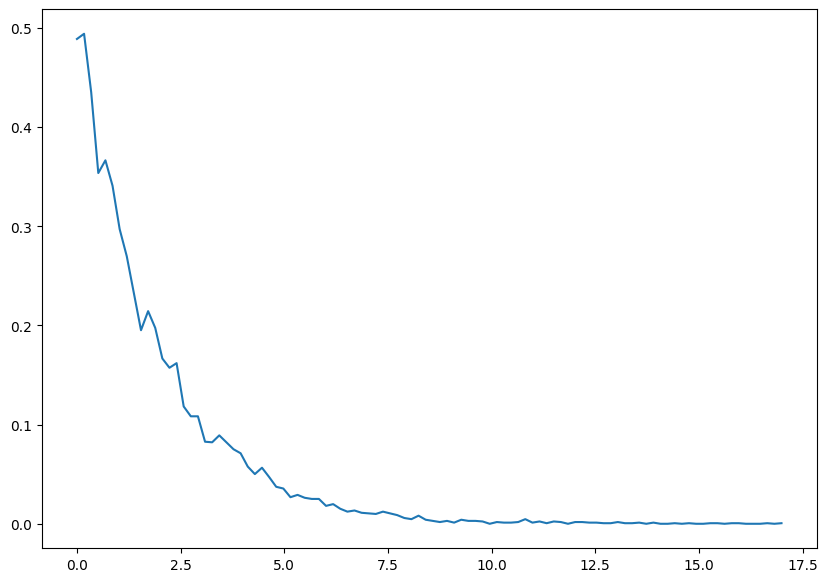

Using least squares
Time:  0.034145355224609375
Result:  [1.89774393]
Time:  0.01587963104248047
[1.96117478]


In [21]:
from scipy.optimize import least_squares,curve_fit
timestamps = generate_timestamps(0, 5, 0.1)
target_scale = 1.894517475
initial_guess = 5
times,target = generate_data(10000,"exp",target_scale,start= 0,end = 10, step = 0.1) #target signature
plot = plt.figure(figsize=(10,7))
plt.plot(times,target)
plt.show()
target_sig = ds.FlatDiscreteSignature(values = target,timestamps = times, k =3).calculate_signature(0,10)
def exp_sig(s):
    vals = generate_values(timestamps,expon(scale = s).pdf)
    vals = ds.ffill_roll(vals)
    signature = ds.FlatDiscreteSignature(values = vals,timestamps = timestamps, k =3)
    return signature.calculate_signature(0,5)
def diff(s):
    
    return target_sig - exp_sig(s)
def exp_pdf(x,s):
    return expon(scale = s).pdf(x)
start = time.time() 
res = least_squares(fun=diff ,x0=initial_guess)
print("Using least squares")
print("Time: ", time.time() - start)
print("Result: ", res.x)
start = time.time()
popt, pcov = curve_fit(exp_pdf,times,target,p0 = initial_guess)
print("Time: ", time.time() - start)
print(popt)


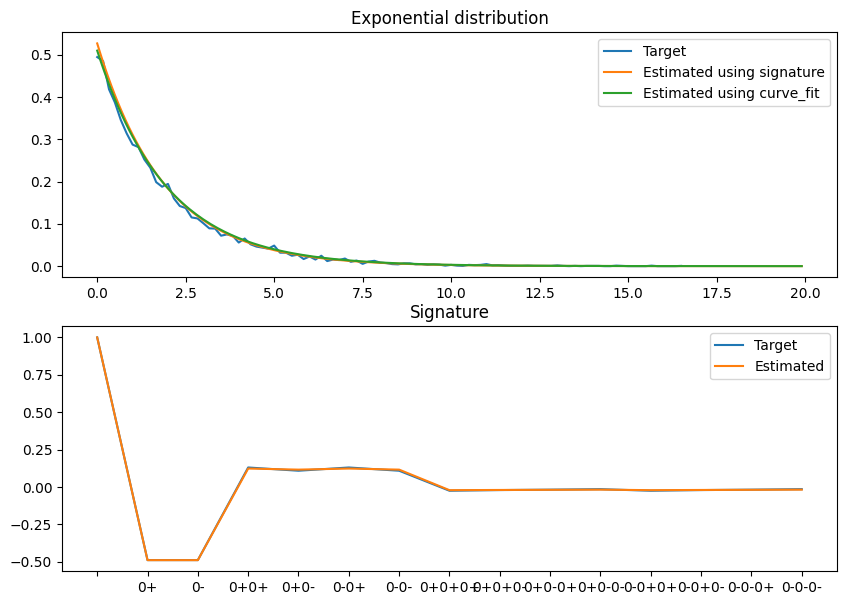

In [22]:

fig,ax = plt.subplots(2,1,figsize=(10,7))
times,target = generate_data(10000,"exp",target_scale,start= 0,end = 10, step = 0.1) #target signature
ax[0].plot(times,target,label = "Target")
timestamps = generate_timestamps(0, 20, 0.1)
ax[0].plot(timestamps,generate_values(timestamps,expon(scale=res.x).pdf),label = "Estimated using signature")
ax[0].plot(timestamps,generate_values(timestamps,expon(scale=popt).pdf),label = "Estimated using curve_fit")
ax[0].set_title("Exponential distribution")
ax[0].legend()
signature = ds.FlatDiscreteSignature(values = ds.ffill_roll(generate_values(timestamps,expon(scale=res.x).pdf)),timestamps = timestamps, k =3)
sig = signature.calculate_signature(0,5)
words = signature.get_words()
x = list(range(0,len(words)))
ax[1].plot(x,target_sig)
ax[1].plot(x,sig)
ax[1].legend(["Target","Estimated"])
ax[1].set_xticks(x)
ax[1].set_xticklabels(words)
ax[1].set_title("Signature")



plt.show()